In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np

import datetime as dt
from scipy.stats import skew, kurtosis
from sklearn import preprocessing, model_selection, metrics

import lightgbm as lgb

import matplotlib.pyplot as plt
%matplotlib inline

from pathlib import Path
import os
pd.options.display.max_columns = 1000

In [2]:
DATA_PATH = Path("data/")

In [3]:
train = pd.read_csv(DATA_PATH/"train.csv", parse_dates=["impression_time"])
test = pd.read_csv(DATA_PATH/"test.csv", parse_dates=["impression_time"])

view_log = pd.read_csv(DATA_PATH/"view_log.csv", parse_dates=["server_time"])
item_data = pd.read_csv(DATA_PATH/"item_data.csv")

view_log_item_data = view_log.merge(item_data, on="item_id", how="left")

In [28]:
view_log_item_data["hour"] = view_log_item_data["server_time"].dt.hour

In [4]:
tmp = view_log_item_data.groupby("user_id").agg({"server_time": [("user_count", "count")],
#                                                                "device_type": [("num_device_types", lambda x: np.unique(x).size)],
                                                 "session_id": [("num_sessions", lambda x: np.unique(x).size)],
                                                 "item_id": [("num_items", lambda x: np.unique(x).size)],
                                                 "item_price": [("mean_item_price", "mean"),
                                                                ("min_item_price", "min"),
                                                                ("max_item_price", "max"),
                                                                ("sd_item_price", lambda x: np.std(x))
#                                                                                 ("skew_item_price", lambda x: skew(x)),
#                                                                                 ("kurtosis_item_price", lambda x: kurtosis(x))
                                                               ],
                                                 "category_1": [("num_category_1", lambda x: np.unique(x).size)],
                                                 "category_2": [("num_category_2", lambda x: np.unique(x).size)],
                                                 "category_3": [("num_category_3", lambda x: np.unique(x).size)],
                                                 "product_type": [("num_product_type", lambda x: np.unique(x).size)],
                                                })
tmp.columns = tmp.columns.droplevel()
tmp = tmp.reset_index(drop=False)

In [30]:
tmpy = view_log_item_data.groupby(["user_id","hour"]).agg({"server_time": [("user_count_hr", "count")],
#                                                                "device_type": [("num_device_types", lambda x: np.unique(x).size)],
                                                 "session_id": [("num_sessions_hr", lambda x: np.unique(x).size)],
                                                 "item_id": [("num_items_hr", lambda x: np.unique(x).size)],
                                                 "item_price": [("mean_item_price_hr", "mean"),
                                                                ("min_item_price_hr", "min"),
                                                                ("max_item_price_hr", "max"),
                                                                ("sd_item_price_hr", lambda x: np.std(x))
#                                                                                 ("skew_item_price", lambda x: skew(x)),
#                                                                                 ("kurtosis_item_price", lambda x: kurtosis(x))
                                                               ],
                                                 "category_1": [("num_category_1_hr", lambda x: np.unique(x).size)],
                                                 "category_2": [("num_category_2_hr", lambda x: np.unique(x).size)],
                                                 "category_3": [("num_category_3_hr", lambda x: np.unique(x).size)],
                                                 "product_type": [("num_product_type_hr", lambda x: np.unique(x).size)],
                                                })
tmpy.columns = tmpy.columns.droplevel()
tmpy = tmpy.reset_index(drop=False)

In [32]:
tmpy.head(10)

,user_id,hour,user_count_hr,num_sessions_hr,num_items_hr,mean_item_price_hr,min_item_price_hr,max_item_price_hr,sd_item_price_hr,num_category_1_hr,num_category_2_hr,num_category_3_hr,num_product_type_hr
0,0,6,2,1,2,4982.000000,4736.0,5228.0,246.000000,2.0,2.0,2.0,2.0
1,0,7,1,1,1,4181.000000,4181.0,4181.0,0.000000,1.0,1.0,1.0,1.0
2,0,9,3,2,3,1154.333333,332.0,2056.0,706.052091,3.0,3.0,3.0,3.0
3,0,10,19,1,11,16587.157895,332.0,92160.0,29562.704250,7.0,10.0,10.0,11.0
4,0,11,3,1,2,1510.333333,1152.0,2227.0,506.759860,2.0,2.0,2.0,2.0
5,0,12,2,1,2,2944.000000,1152.0,4736.0,1792.000000,2.0,2.0,2.0,2.0
6,0,14,7,2,2,3284.000000,332.0,3776.0,1205.148953,2.0,2.0,2.0,2.0
7,0,15,3,2,3,8714.333333,1075.0,19840.0,8047.657893,3.0,3.0,3.0,3.0
8,0,20,2,1,1,1152.000000,1152.0,1152.0,0.000000,1.0,1.0,1.0,1.0
9,1,1,6,1,6,3578.166667,383.0,12595.0,4132.960901,6.0,6.0,6.0,6.0


In [5]:
tmpx = view_log_item_data[view_log_item_data['server_time'] >= '2018-11-15'].groupby("user_id").agg({"server_time": [("user_count_rct", "count")],
#                                                                "device_type": [("num_device_types", lambda x: np.unique(x).size)],
                                                 "session_id": [("num_sessions_rct", lambda x: np.unique(x).size)],
                                                 "item_id": [("num_items_rct", lambda x: np.unique(x).size)],
                                                 "item_price": [("mean_item_price_rct", "mean"),
                                                                ("min_item_price_rct", "min"),
                                                                ("max_item_price_rct", "max"),
                                                                ("sd_item_price_rct", lambda x: np.std(x))
#                                                                                 ("skew_item_price", lambda x: skew(x)),
#                                                                                 ("kurtosis_item_price", lambda x: kurtosis(x))
                                                               ],
                                                 "category_1": [("num_category_1_rct", lambda x: np.unique(x).size)],
                                                 "category_2": [("num_category_2_rct", lambda x: np.unique(x).size)],
                                                 "category_3": [("num_category_3_rct", lambda x: np.unique(x).size)],
                                                 "product_type": [("num_product_type_rct", lambda x: np.unique(x).size)],
                                                })
tmpx.columns = tmpx.columns.droplevel()
tmpx = tmpx.reset_index(drop=False)

In [6]:
tmp1 = view_log_item_data.pivot_table(index="user_id", 
                                      columns="category_1", 
                                      values="server_time", aggfunc="count").fillna(0)
tmp1.columns.name = None
tmp1.columns = [f"category_1_{int(category_type)}" for category_type in tmp1.columns]
tmp1 = tmp1.reset_index()

In [7]:
tmpx1 = view_log_item_data[view_log_item_data['server_time'] >= '2018-11-15'].pivot_table(index="user_id", 
                                      columns="category_1", 
                                      values="server_time", aggfunc="count").fillna(0)
tmpx1.columns.name = None
tmpx1.columns = [f"category_1_rct_{int(category_type)}" for category_type in tmpx1.columns]
tmpx1 = tmpx1.reset_index()

In [8]:
tmp2 = view_log_item_data.pivot_table(index="user_id", 
                                      columns="category_2", 
                                      values="server_time", aggfunc="count").fillna(0)
tmp2.columns.name = None
tmp2.columns = [f"category_2_{int(category_type)}" for category_type in tmp2.columns]
tmp2 = tmp2.reset_index()

In [9]:
tmpx2 = view_log_item_data[view_log_item_data['server_time'] >= '2018-11-15'].pivot_table(index="user_id", 
                                      columns="category_2", 
                                      values="server_time", aggfunc="count").fillna(0)
tmpx2.columns.name = None
tmpx2.columns = [f"category_2_rct_{int(category_type)}" for category_type in tmpx2.columns]
tmpx2 = tmpx2.reset_index()

In [10]:
train["is_train"] = 1
test["is_train"] = 0

panel = pd.concat([train, test], sort=False, ignore_index=True)

In [11]:
panel = (panel.merge(tmp, on="user_id", how="left")
              .merge(tmp1, on="user_id", how="left")
              .merge(tmp2, on="user_id", how="left")
        .merge(tmpx, on="user_id", how="left")
        .merge(tmpx1, on="user_id", how="left")
        .merge(tmpx2, on="user_id", how="left"))

In [12]:
os_version_mapper = {"latest": 2, "intermediate": 1, "old": 0}
panel["os_version"] = panel["os_version"].map(os_version_mapper)

In [13]:
# panel["day"] = panel["impression_time"].dt.day
panel["dayofweek"] = panel["impression_time"].dt.dayofweek
panel["hour"] = panel["impression_time"].dt.hour

In [33]:
panel = panel.merge(tmpy, on=["user_id","hour"], how="left")

In [34]:
for col in ["user_id", "app_code", 
            ["user_id", "app_code"], ["app_code", "os_version"]]:
    if not isinstance(col, list):
        col = [col]
    col_name = "_".join(col)
    all_df = panel[["impression_id"] + col].copy()
    gdf = all_df.groupby(col)["impression_id"].count().reset_index()
    gdf.columns = col + [col_name+"_count"]
    panel = pd.merge(panel, gdf, on=col, how="left")

In [35]:
columns_for_model = np.setdiff1d(panel.columns.values, ["impression_id",
                                                        "impression_time",
                                                        "is_click",
                                                        "is_train"]).tolist()
train_X = panel.loc[panel["is_train"] == 1, columns_for_model + ["is_click"]].reset_index(drop=True)
test_X = panel.loc[panel["is_train"] == 0, ["impression_id"]+columns_for_model].reset_index(drop=True)

train_y = train_X["is_click"].values

train_X = train_X.drop(["is_click"], axis=1)
test_ids = test_X["impression_id"].values
test_X = test_X.drop(["impression_id"], axis=1)
print(train_X.shape, test_X.shape)

(237609, 237) (90675, 237)


In [36]:
columns_for_model

['app_code',
 'app_code_count_x',
 'app_code_count_y',
 'app_code_os_version_count_x',
 'app_code_os_version_count_y',
 'category_1_0',
 'category_1_1',
 'category_1_10',
 'category_1_11',
 'category_1_12',
 'category_1_13',
 'category_1_14',
 'category_1_15',
 'category_1_16',
 'category_1_17',
 'category_1_2',
 'category_1_4',
 'category_1_5',
 'category_1_6',
 'category_1_7',
 'category_1_8',
 'category_1_9',
 'category_1_rct_0',
 'category_1_rct_1',
 'category_1_rct_10',
 'category_1_rct_11',
 'category_1_rct_12',
 'category_1_rct_13',
 'category_1_rct_14',
 'category_1_rct_15',
 'category_1_rct_16',
 'category_1_rct_17',
 'category_1_rct_2',
 'category_1_rct_4',
 'category_1_rct_6',
 'category_1_rct_7',
 'category_1_rct_8',
 'category_1_rct_9',
 'category_2_0',
 'category_2_1',
 'category_2_10',
 'category_2_11',
 'category_2_12',
 'category_2_13',
 'category_2_14',
 'category_2_15',
 'category_2_16',
 'category_2_17',
 'category_2_18',
 'category_2_19',
 'category_2_2',
 'categor

In [37]:
def runLGB(train_X, train_y, test_X, test_y=None, test_X2=None, dep=8, seed=0, data_leaf=511, hessian_leaf=50):  
    params = {}
    params["objective"] = "binary"
    params['metric'] = 'auc'
#     params["max_depth"] = dep
    params["num_leaves"] = 63
    params["min_data_in_leaf"] = data_leaf
    params["min_sum_hessian_in_leaf"] = hessian_leaf
    params["learning_rate"] = 0.01
    params["bagging_fraction"] = 0.913
    params["feature_fraction"] = 0.2
    params["feature_fraction_seed"] = seed
    params["bagging_freq"] = 8
    params["bagging_seed"] = seed
    params["lambda_l2"] = 0.95
    params["lambda_l1"] = 0.95
    params["verbosity"] = -1
    num_rounds = 20000

    plst = list(params.items())
    lgtrain = lgb.Dataset(train_X, label=train_y)

    if test_y is not None:
        lgtest = lgb.Dataset(test_X, label=test_y)
        model = lgb.train(params, lgtrain, num_rounds, valid_sets=[lgtest], early_stopping_rounds=200, verbose_eval=500)
    else:
        lgtest = lgb.DMatrix(test_X)
        model = lgb.train(params, lgtrain, num_rounds)

    pred_test_y = model.predict(test_X, num_iteration=model.best_iteration)
    pred_test_y2 = model.predict(test_X2, num_iteration=model.best_iteration)

    loss = 0
    if test_y is not None:
        loss = metrics.roc_auc_score(test_y, pred_test_y)
        print(loss)
        return model, loss, pred_test_y, pred_test_y2
    else:
        return model, loss, pred_test_y, pred_test_y2

In [40]:
print("Building model..")
cv_scores = []
pred_test_full = 0
pred_train = np.zeros(train_X.shape[0])
n_splits = 3
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=7988)
model_name = "lgb"
for dev_index, val_index in kf.split(train_X, train_y):
    dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]

    pred_val = 0
    pred_test = 0
    n_models = 0.

    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, seed=2019)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, data_leaf=450, hessian_leaf=30, seed=9873)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, data_leaf=600, hessian_leaf=70, seed=4568)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    pred_val /= n_models
    pred_test /= n_models
    
    loss = metrics.roc_auc_score(val_y, pred_val)
        
    pred_train[val_index] = pred_val
    pred_test_full += pred_test / n_splits
    cv_scores.append(loss)
#     break
print(np.mean(cv_scores))

Building model..
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.792896
[1000]	valid_0's auc: 0.798491
[1500]	valid_0's auc: 0.800019
[2000]	valid_0's auc: 0.800369
Early stopping, best iteration is:
[1957]	valid_0's auc: 0.800436
0.800435763417789
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.794555
[1000]	valid_0's auc: 0.799453
[1500]	valid_0's auc: 0.800621
[2000]	valid_0's auc: 0.800954
Early stopping, best iteration is:
[1855]	valid_0's auc: 0.801068
0.8010684682150403
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.791435
[1000]	valid_0's auc: 0.797576
[1500]	valid_0's auc: 0.799374
[2000]	valid_0's auc: 0.799892
Early stopping, best iteration is:
[1941]	valid_0's auc: 0.799953
0.799953441976462
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.799957
[1000]	valid_0's auc: 0.804846
[1500]	valid_0's auc: 0.806409
Early stopping, b

In [ ]:
0.8030428554716673

In [19]:
print("Building model..")
cv_scores = []
pred_test_full = 0
pred_train = np.zeros(train_X.shape[0])
n_splits = 3
kf = model_selection.KFold(n_splits=n_splits, shuffle=True, random_state=7988)
model_name = "lgb"
for dev_index, val_index in kf.split(train_X, train_y):
    dev_X, val_X = train_X.iloc[dev_index,:], train_X.iloc[val_index,:]
    dev_y, val_y = train_y[dev_index], train_y[val_index]

    pred_val = 0
    pred_test = 0
    n_models = 0.

    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, seed=2019)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, data_leaf=450, hessian_leaf=30, seed=9873)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    model, loss, pred_v, pred_t = runLGB(dev_X, dev_y, val_X, val_y, test_X, data_leaf=600, hessian_leaf=70, seed=4568)
    pred_val += pred_v
    pred_test += pred_t
    n_models += 1
    
    pred_val /= n_models
    pred_test /= n_models
    
    loss = metrics.roc_auc_score(val_y, pred_val)
        
    pred_train[val_index] = pred_val
    pred_test_full += pred_test / n_splits
    cv_scores.append(loss)
#     break
print(np.mean(cv_scores))

Building model..
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.741377
[1000]	valid_0's auc: 0.747758
[1500]	valid_0's auc: 0.748955
Early stopping, best iteration is:
[1665]	valid_0's auc: 0.748992
0.748992437044109
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.742417
[1000]	valid_0's auc: 0.748435
[1500]	valid_0's auc: 0.749399
Early stopping, best iteration is:
[1331]	valid_0's auc: 0.749581
0.749581106793487
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.738783
[1000]	valid_0's auc: 0.745598
[1500]	valid_0's auc: 0.747498
[2000]	valid_0's auc: 0.74785
Early stopping, best iteration is:
[2151]	valid_0's auc: 0.747944
0.7479444991058457
Training until validation scores don't improve for 200 rounds.
[500]	valid_0's auc: 0.744062
[1000]	valid_0's auc: 0.748774
[1500]	valid_0's auc: 0.74968
Early stopping, best iteration is:
[1425]	valid_0's auc: 0.749772
0.7497716080599

In [41]:
submit = pd.DataFrame({"impression_id": test_ids, "is_click": pred_test_full})

In [42]:
max(submit['is_click'])

0.6363009136562348

In [43]:
submit.head()

,impression_id,is_click
0,a9e7126a585a69a32bc7414e9d0c0ada,0.015766
1,caac14a5bf2ba283db7708bb34855760,0.006936
2,13f10ba306a19ce7bec2f3cae507b698,0.117178
3,39c4b4dc0e9701b55a0a4f072008fb3f,0.024415
4,bf5a572cca75f5fc67f4b14e58b11d70,0.184652


In [44]:
submit.to_csv("submit_baseline_kfold_0_8030.csv", index=False)

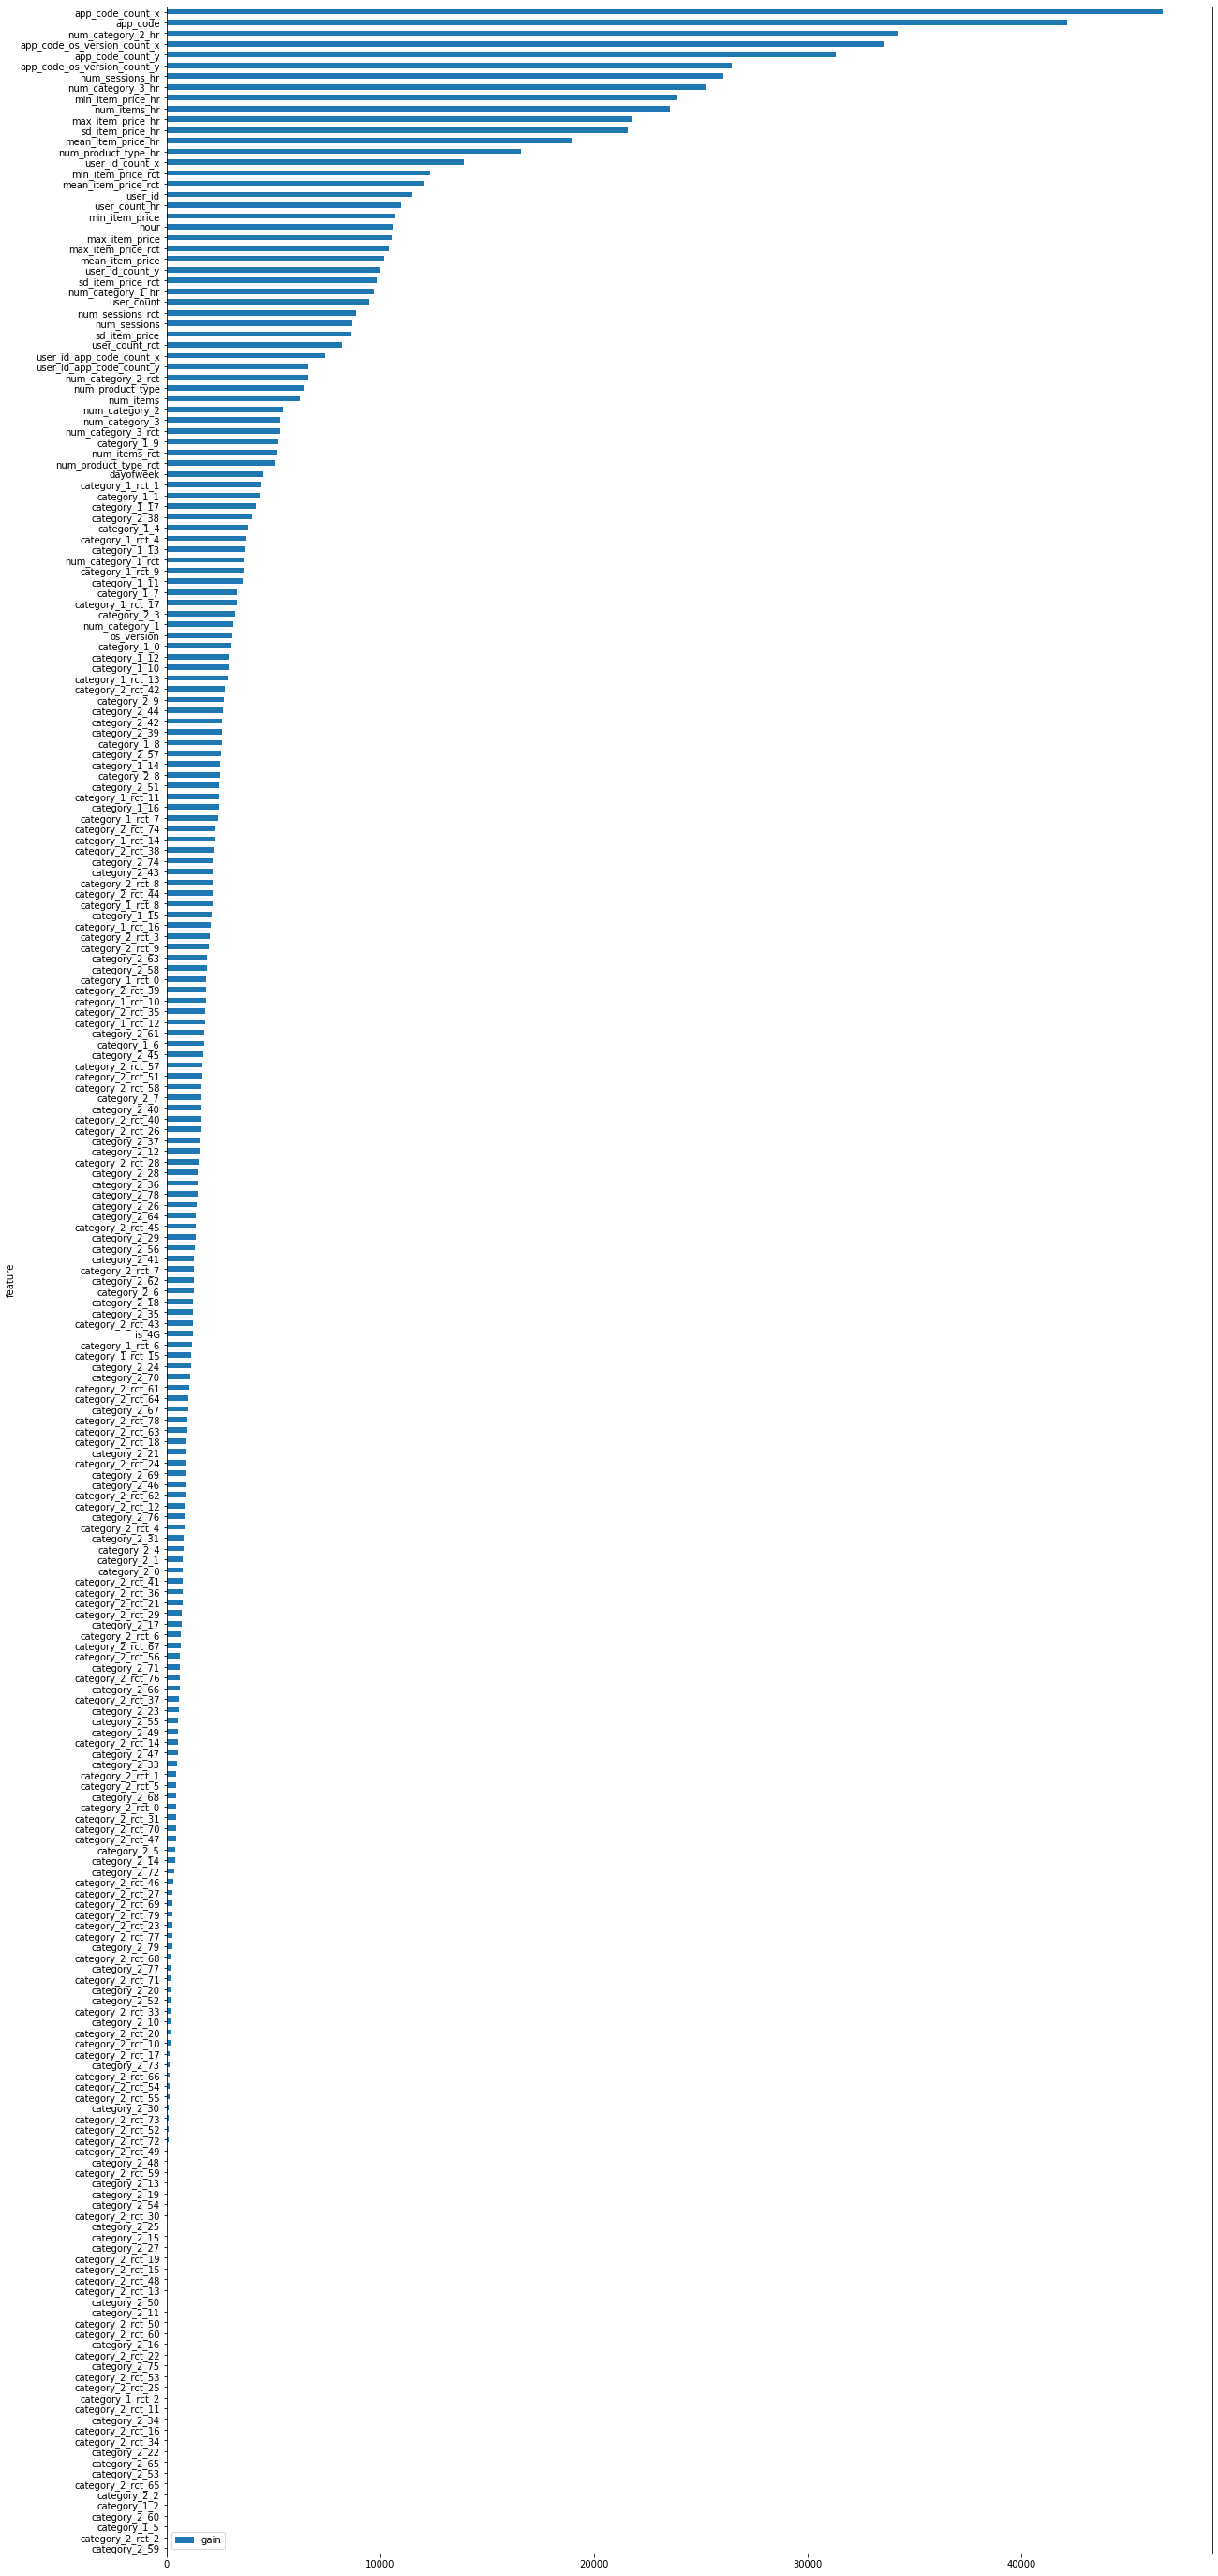

In [39]:
(pd.DataFrame({"feature": model.feature_name(), 
              "gain": model.feature_importance(importance_type="gain")})
     .sort_values("gain", ascending=True).set_index("feature").plot(kind="barh", figsize=(20,50)))